# Train and Compare Machine Learning Models
* To succecfully run this notebook you need a python3.7 kernel with requirements in ./sagemaker-custom-image/requirements.txt

## This notebook will help you to do:
* Import training and test data
* Run many ML algorithms using SageMaker Autopilot
* Run many ML algorithms using H2O AutoML
* Compare all model performance in test dataset
* Choosing and save the best model

# 1. Parameters

In [4]:
#Name
ModelName = 'prop_apply_prospects'
#Version
ModelVersion = 'v12'
#Model ID
ModelId = ModelName+'_'+ModelVersion

#Setting the model target variable name
VarTarget = 'target'

#process outputs such as MOJO model, images and performance of tested models
OutputPath = './output_model/'

#If you have a huge dataset, I should consider use a small sample for first execution
PctSampleSize = 1

#Bucket already created on S3
bucket = 'data-science-lab'

#Selected Feature difined in Data_Prep
CAT = [ 'declared_seniority'
       ,'last_company_classification'
       ,'company_classification_migration'
       ,'job_area'
       ,'declared_seniority_migration'
       ,'prospect_location_state'
       ,'prospect_area_migration'
      ]
#float
NUM = [ 'prospect_smart_skills_qty'
       ,'prospect_experiences_qty'
       ,'prospect_companies_qty'
       ,'total_experience_months'
       ,'experience_duration_months_min'
       ,'experience_duration_months_clean_avg'
       ,'experience_duration_months_clean_stddev'
       ,'max_salary_offered'
       ,'last_experience_duration_months_to_avg'
       ,'prospect_linkedin_about_word_count'
       ,'last_experience_descriptions_word_count'       
       ,'import_policy_word_count'
       ,'job_technical_requirements_word_count'
       ,'job_validation_questions_word_count'
       ,'all_company_classifications_count'
      ]
selected_features = CAT + NUM

# 2. Import Libraries

In [11]:
import sys
sys.path.append('/var/lang/lib/python37.zip')
sys.path.append('/var/lang/lib/python3.7')
sys.path.append('/var/lang/lib/python3.7/lib-dynload')
sys.path.append('/var/lang/lib/python3.7/site-packages')
sys.path.remove('/opt/.sagemakerinternal/conda/lib/python3.7/site-packages')

In [30]:
import functools
import os
from time import gmtime, strftime, sleep
import datetime as dt
import pandas as pd
import numpy as np
import glob
import boto3
import awswrangler as wr
import sagemaker
from sagemaker import get_execution_role
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import CSVDeserializer
import h2o
import matplotlib.pyplot as plt
from sklearn import metrics
import shutil
import seaborn as sns
from io import StringIO

# 3. Importing Data for Modeling

In [7]:
#Create boto3 sesesion for Athena, SageMaker and S3 connection
my_boto3_session = boto3.Session(region_name='us-east-1',
    aws_access_key_id='xxxx',
    aws_secret_access_key='xxxxx',
    aws_session_token='xxxxxx')

In [8]:
query4="select * from datascience.%s" % ModelName
dataprep_df_full = wr.athena.read_sql_query(query4, database="datascience", boto3_session=my_boto3_session, s3_output='s3://query-temp-result')

In [9]:
#Work with a sample data if the PctSampleSize is less than 1
if PctSampleSize == 1:
    dataprep_df = dataprep_df_full.copy()
else:
    dataprep_df = dataprep_df_full.sample(frac=PctSampleSize, replace=False, random_state=1)
del dataprep_df_full

In [10]:
#Numeric features must be float type
for col_name in NUM:
    dataprep_df[col_name] = dataprep_df[col_name].astype(float)

#Categorical features must be string type and null values will be filled with "missing"
for col_name in CAT:
    dataprep_df[col_name] = dataprep_df[col_name].astype(str)

# 4. Modeling

## 4.1 Traning Models with SageMaker Autopilot

### 4.1.1 SageMaker Setup

In [8]:
region = my_boto3_session.region_name
session = sagemaker.Session(my_boto3_session)

# You can modify the following to use a bucket of your choosing
prefix = "models/%s/sagemaker-temp" % ModelName

role = get_execution_role()

# # This is the client we will use to interact with SageMaker AutoPilot
sm = my_boto3_session.client(service_name="sagemaker", region_name=region)

input_data_config = [
    {
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": 's3://%s/databases/%s/train_data/train_data.csv' % (bucket, ModelName),
            }
        },
        "TargetAttributeName": VarTarget,
    }
]

output_data_config = {"S3OutputPath": "s3://%s/%s" % (bucket, prefix)}

### 4.1.2 SageMaker Setup and Run Auto Pilot

In [9]:
timestamp_suffix = strftime("%d-%H-%M-%S", gmtime())

auto_ml_job_name = "autopilot-" + ModelName.replace('_', '-')[0:10] + '-' + timestamp_suffix
print("AutoMLJobName: " + auto_ml_job_name)

#Run SageMaker Autopilot
sm.create_auto_ml_job(
    AutoMLJobName=auto_ml_job_name,
    InputDataConfig=input_data_config,
    OutputDataConfig=output_data_config,
    AutoMLJobConfig={"CompletionCriteria": {"MaxCandidates": 20}},
    RoleArn=role
)

AutoMLJobName: autopilot-prop-apply-28-01-28-04


{'AutoMLJobArn': 'arn:aws:sagemaker:us-east-1:245799943033:automl-job/autopilot-prop-apply-28-01-28-04',
 'ResponseMetadata': {'RequestId': '6accaac1-1750-4f5a-b452-250f9ead3bc8',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '6accaac1-1750-4f5a-b452-250f9ead3bc8',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '103',
   'date': 'Tue, 28 Jun 2022 01:28:05 GMT'},
  'RetryAttempts': 0}}

In [10]:
print("JobStatus - Secondary Status")
print("------------------------------")

describe_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
print(describe_response["AutoMLJobStatus"] + " - " + describe_response["AutoMLJobSecondaryStatus"] + " - " + strftime("%d-%H-%M-%S", gmtime()))
job_run_status = describe_response["AutoMLJobStatus"]

while job_run_status not in ("Failed", "Completed", "Stopped"):
    describe_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
    job_run_status = describe_response["AutoMLJobStatus"]

    print(
        describe_response["AutoMLJobStatus"] + " - " + describe_response["AutoMLJobSecondaryStatus"] + " - " + strftime("%d-%H-%M-%S", gmtime())
    )
    sleep(30)

JobStatus - Secondary Status
------------------------------
Completed - Completed - 28-17-05-40


### 4.1.3 Create SageMaker Endpoint and Predictor with the Best Candidate

In [ ]:
#Select best candidate
best_candidate = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)["BestCandidate"]
best_candidate_name = best_candidate["CandidateName"]

#Add probability and probabilities to the SAGEMAKER_INFERENCE_OUTPUT
for i in range(len(best_candidate["InferenceContainers"])):
    best_candidate["InferenceContainers"][i]['Environment']['SAGEMAKER_INFERENCE_INPUT']='predicted_label, probability, probabilities'
    best_candidate["InferenceContainers"][i]['Environment']['SAGEMAKER_INFERENCE_OUTPUT']='predicted_label, probability, probabilities'

#Create endpoint configuration
timestamp_suffix = strftime("%d-%H-%M-%S", gmtime())
model_name = best_candidate_name + timestamp_suffix + "-model"
model_arn = sm.create_model(
    Containers=best_candidate["InferenceContainers"], ModelName=model_name, ExecutionRoleArn=role
)

epc_name = best_candidate_name + timestamp_suffix + "-epc"
ep_config = sm.create_endpoint_config(
    EndpointConfigName=epc_name,
    ProductionVariants=[
        {
            "InstanceType": "ml.m5.2xlarge",
            "InitialInstanceCount": 1,
            "ModelName": model_name,
            "VariantName": "main",
        }
    ],
)

#Create end endpoint
ep_name = best_candidate_name + timestamp_suffix + "-ep"
create_endpoint_response = sm.create_endpoint(EndpointName=ep_name, EndpointConfigName=epc_name)
sm.get_waiter("endpoint_in_service").wait(EndpointName=ep_name)
print("ep_name: " + str(ep_name))

In [44]:
#Create Predictor
sm_predictor = Predictor(
    endpoint_name=ep_name,
    sagemaker_session=session,
    serializer=CSVSerializer(),
    deserializer=CSVDeserializer(),
)

## 4.2 Traning Models with H2O AutoML

## 4.2.1 Creating context and H2O and Importing data into the H2O context

In [16]:
# Number of threads, nthreads = -1, means use all cores on your machine
# max_mem_size is the maximum memory (in GB) to allocate to H2O
h2o.init(nthreads = -1, max_mem_size = '10G')
# h2o.init(nthreads = -1)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_332"; OpenJDK Runtime Environment Corretto-8.332.08.1 (build 1.8.0_332-b08); OpenJDK 64-Bit Server VM Corretto-8.332.08.1 (build 25.332-b08, mixed mode)
  Starting server from /var/lang/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpzn848l0k
  JVM stdout: /tmp/tmpzn848l0k/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpzn848l0k/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/GMT
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.2
H2O_cluster_version_age:,1 month and 2 days
H2O_cluster_name:,H2O_from_python_unknownUser_7g9fed
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,706 Mb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [17]:
#Import TRAINING base to the H20 context
data_hdf = h2o.H2OFrame(dataprep_df.query('partition_0 == "train_data"').loc[:, (selected_features+[VarTarget])])

# Conversion of Target variables and categorical features to factor (enum)
#no H2O it is necessary that the categorical variables are transformed into a factor
data_hdf[VarTarget] = data_hdf[VarTarget].asfactor()
for col_name in CAT:
    data_hdf[col_name] = data_hdf[col_name].asfactor()
for col_name in NUM:
    data_hdf[col_name] = data_hdf[col_name].asnumeric()
    
# Partition data into 90%, 10% chunks
# Setting a seed will guarantee reproducibility
train_hdf, valid_hdf = data_hdf.split_frame(ratios=[0.90], destination_frames=['train_hdf', 'valid_hdf'], seed=1)
        
#Notice that `split_frame()` uses approximate splitting not exact splitting (for efficiency), so these are not exactly 90%, 10% of the total rows.
print('Training: ' + str(train_hdf.nrow))
print('Validation: ' + str(valid_hdf.nrow))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Training: 187835
Validation: 21081


In [18]:
#Import TEST base to the H20 context
test_hdf = h2o.H2OFrame(dataprep_df.query('partition_0 == "test_data"').loc[:, (selected_features+[VarTarget])])

# Conversion of Target variables and categorical features to factor (enum)
#no H2O it is necessary that the categorical variables are transformed into a factor
test_hdf[VarTarget] = test_hdf[VarTarget].asfactor()
for col_name in CAT:
    test_hdf[col_name] = test_hdf[col_name].asfactor()
for col_name in NUM:
    test_hdf[col_name] = test_hdf[col_name].asnumeric()
    
print('Test: ' + str(test_hdf.nrow))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Test: 47181


## 4.2.2 Train the H2O Champion algorithm with new data

In [19]:
## This is the champion previous trained algorithms that will be used as comparison for the new experiments
vModel='h2o_champion_'

#Execution time of the model
start = dt.datetime.now()

from h2o.estimators.gbm import H2OGradientBoostingEstimator
h2o_champion = H2OGradientBoostingEstimator(model_id='%s%s%s' % (vModel, ModelId, str(dt.datetime.now())[:19].replace('-',"").replace(':',"").replace(' ',"_")),
                                    nfolds= 5,
                                    keep_cross_validation_models= False,
                                    keep_cross_validation_predictions= True,
                                    keep_cross_validation_fold_assignment= False,
                                    score_each_iteration= False,
                                    score_tree_interval= 5,
                                    fold_assignment='Modulo',
                                    fold_column= None,
                                    ignore_const_cols= True,
                                    offset_column= None,
                                    weights_column= None,
                                    balance_classes= False,
                                    class_sampling_factors= None,
                                    max_after_balance_size= 5.0,
                                    max_confusion_matrix_size= 20,
                                    ntrees= 120,
                                    max_depth= 4,
                                    min_rows= 100.0,
                                    nbins= 20,
                                    nbins_top_level= 1024,
                                    nbins_cats= 1024,
                                    r2_stopping= 1.7976931348623157e+308,
                                    stopping_rounds= 2,
                                    stopping_metric='AUCPR',
                                    stopping_tolerance= 0.002303474948339114,
                                    max_runtime_secs= 31688.0,
                                    seed= 101,
                                    build_tree_one_node= False,
                                    learn_rate= 0.1,
                                    learn_rate_annealing= 1.0,
                                    distribution='bernoulli',
                                    quantile_alpha= 0.5,
                                    tweedie_power= 1.5,
                                    huber_alpha= 0.9,
                                    checkpoint= None,
                                    sample_rate= 0.9,
                                    sample_rate_per_class= None,
                                    col_sample_rate= 0.4,
                                    col_sample_rate_change_per_level= 1.0,
                                    col_sample_rate_per_tree= 0.7,
                                    min_split_improvement= 1e-05,
                                    histogram_type='UniformAdaptive',
                                    max_abs_leafnode_pred= 1.7976931348623157e+308,
                                    pred_noise_bandwidth= 0.0,
                                    categorical_encoding='Enum',
                                    calibrate_model= False,
                                    calibration_frame= None,
                                    custom_metric_func= None,
                                    custom_distribution_func= None,
                                    export_checkpoints_dir= None,
                                    monotone_constraints= None,
                                    check_constant_response= True,
                                    gainslift_bins= -1,
                                    auc_type='AUTO',
                                    interaction_constraints= None)

# The use of a validation_frame is recommended with using early stopping
h2o_champion.train(x=selected_features, y=VarTarget, training_frame=train_hdf, validation_frame=valid_hdf)

#Execution time of the model
stop = dt.datetime.now()
execution_time = stop-start
print("\n"+ "Execution time: " + str(execution_time) + "\n")
print(h2o_champion)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%

Execution time: 0:01:50.189452

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  h2o_champion_prop_apply_prospects_v1220220628_171140


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,108.0,108.0,37350.0,4.0,4.0,4.0,6.0,16.0,14.87037




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.08065414411347117
RMSE: 0.2839967325753435
LogLoss: 0.28675727714882404
Mean Per-Class Error: 0.36719401958747844
AUC: 0.7256648400040994
AUCPR: 0.24643936774699526
Gini: 0.45132968000819873

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.14361646122491786: 


,,0,1,Error,Rate
0,0,146121.0,23696.0,0.1395,(23696.0/169817.0)
1,1,10718.0,7300.0,0.5948,(10718.0/18018.0)
2,Total,156839.0,30996.0,0.1832,(34414.0/187835.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.143616,0.297874,194.0
1,max f2,0.089016,0.426595,272.0
2,max f0point5,0.215602,0.285211,128.0
3,max accuracy,0.372651,0.905199,49.0
4,max precision,0.799872,1.000000,0.0
5,max recall,0.016865,1.000000,396.0
6,max specificity,0.799872,1.000000,0.0
7,max absolute_mcc,0.143616,0.210723,194.0
8,max min_per_class_accuracy,0.097469,0.662613,258.0
9,max mean_per_class_accuracy,0.100009,0.664753,254.0



Gains/Lift Table: Avg response rate:  9.59 %, avg score:  9.59 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010003,0.322584,5.259585,5.259585,0.504524,0.391871,0.504524,0.391871,0.052614,0.052614,425.958519,425.958519,0.047132
1,2,0.020002,0.277991,3.680339,4.470172,0.353035,0.297770,0.428800,0.344833,0.036797,0.089411,268.033945,347.017249,0.076773
2,3,0.030005,0.251427,3.101380,4.013827,0.297499,0.263541,0.385025,0.317731,0.031025,0.120435,210.137987,301.382733,0.100025
3,4,0.040003,0.233217,2.797724,3.709882,0.268371,0.241980,0.355869,0.298798,0.027972,0.148407,179.772411,270.988245,0.119906
4,5,0.050001,0.219134,2.703356,3.508620,0.259318,0.225894,0.336563,0.284220,0.027029,0.175436,170.335643,250.862011,0.138743
5,6,0.100003,0.173864,2.218833,2.863727,0.212841,0.193768,0.274702,0.238994,0.110945,0.286380,121.883316,186.372663,0.206153
6,7,0.150004,0.149017,1.845883,2.524445,0.177066,0.160448,0.242156,0.212812,0.092297,0.378677,84.588271,152.444533,0.252936
7,8,0.200000,0.132220,1.541915,2.278832,0.147908,0.140124,0.218596,0.194642,0.077090,0.455766,54.191467,127.883228,0.282904
8,9,0.300003,0.109059,1.355830,1.971159,0.130057,0.119969,0.189083,0.169750,0.135587,0.591353,35.583026,97.115948,0.322263
9,10,0.400000,0.092446,1.051754,1.741314,0.100889,0.100338,0.167035,0.152398,0.105173,0.696526,5.175405,74.131424,0.327988




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.0819266838259149
RMSE: 0.28622837704517506
LogLoss: 0.2946171020650431
Mean Per-Class Error: 0.38532301737153835
AUC: 0.6739097476534847
AUCPR: 0.18363066214112522
Gini: 0.3478194953069693

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.12995569720551842: 


,,0,1,Error,Rate
0,0,15491.0,3608.0,0.1889,(3608.0/19099.0)
1,1,1153.0,829.0,0.5817,(1153.0/1982.0)
2,Total,16644.0,4437.0,0.2258,(4761.0/21081.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.129956,0.258296,198.0
1,max f2,0.069850,0.381383,300.0
2,max f0point5,0.207397,0.237014,114.0
3,max accuracy,0.718871,0.905934,0.0
4,max precision,0.475928,0.416667,7.0
5,max recall,0.017596,1.000000,395.0
6,max specificity,0.718871,0.999948,0.0
7,max absolute_mcc,0.129956,0.164206,198.0
8,max min_per_class_accuracy,0.092923,0.622603,255.0
9,max mean_per_class_accuracy,0.102504,0.627254,240.0



Gains/Lift Table: Avg response rate:  9.40 %, avg score:  9.60 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010009,0.314732,3.679832,3.679832,0.345972,0.379530,0.345972,0.379530,0.036831,0.036831,267.983176,267.983176,0.029606
1,2,0.020018,0.274934,2.923702,3.301767,0.274882,0.293579,0.310427,0.336554,0.029263,0.066095,192.370194,230.176685,0.050858
2,3,0.030027,0.248585,2.470024,3.024519,0.232227,0.261952,0.284360,0.311687,0.024723,0.090817,147.002406,202.451925,0.067099
3,4,0.040036,0.231406,3.024519,3.024519,0.284360,0.240098,0.284360,0.293790,0.030272,0.121090,202.451925,202.451925,0.089465
4,5,0.050045,0.218086,2.419615,2.903538,0.227488,0.224013,0.272986,0.279834,0.024218,0.145308,141.961540,190.353848,0.105149
5,6,0.100043,0.174644,1.887072,2.395546,0.177419,0.194316,0.225225,0.237096,0.094349,0.239657,88.707236,139.554640,0.154103
6,7,0.150040,0.149258,1.644881,2.145404,0.154649,0.161042,0.201707,0.211752,0.082240,0.321897,64.488126,114.540380,0.189691
7,8,0.200038,0.132677,1.594425,2.007692,0.149905,0.140227,0.188760,0.193875,0.079717,0.401615,59.442478,100.769171,0.222495
8,9,0.300033,0.109405,1.185727,1.733747,0.111480,0.120263,0.163004,0.169342,0.118567,0.520182,18.572729,73.374688,0.242994
9,10,0.400028,0.092192,1.034358,1.558920,0.097249,0.100538,0.146567,0.152143,0.103431,0.623613,3.435784,55.892036,0.246787




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.08284226200558185
RMSE: 0.2878233173417016
LogLoss: 0.2960232481349756
Mean Per-Class Error: 0.375933637351811
AUC: 0.6873240135177986
AUCPR: 0.1960628349018331
Gini: 0.3746480270355972

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.12311476147016441: 


,,0,1,Error,Rate
0,0,133775.0,36042.0,0.2122,(36042.0/169817.0)
1,1,9723.0,8295.0,0.5396,(9723.0/18018.0)
2,Total,143498.0,44337.0,0.2436,(45765.0/187835.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.123115,0.266057,225.0
1,max f2,0.079091,0.399576,292.0
2,max f0point5,0.169355,0.238069,170.0
3,max accuracy,0.660678,0.904091,4.0
4,max precision,0.660678,0.636364,4.0
5,max recall,0.012766,1.000000,398.0
6,max specificity,0.754524,0.999988,0.0
7,max absolute_mcc,0.123115,0.172077,225.0
8,max min_per_class_accuracy,0.094179,0.635587,267.0
9,max mean_per_class_accuracy,0.091799,0.637150,271.0



Gains/Lift Table: Avg response rate:  9.59 %, avg score:  9.57 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010003,0.323257,3.889208,3.889208,0.373071,0.386966,0.373071,0.386966,0.038906,0.038906,288.920804,288.920804,0.031969
1,2,0.020002,0.278047,2.914296,3.401882,0.279553,0.297693,0.326324,0.342341,0.029138,0.068043,191.429595,240.188174,0.053139
2,3,0.030005,0.251678,2.496639,3.100080,0.239489,0.263932,0.297374,0.316200,0.024975,0.093018,149.663854,210.008047,0.069699
3,4,0.040003,0.233292,2.459111,2.939881,0.235889,0.242072,0.282007,0.297673,0.024587,0.117605,145.911067,193.988067,0.085835
4,5,0.050001,0.218773,2.264824,2.804898,0.217252,0.225811,0.269059,0.283304,0.022644,0.140249,126.482428,180.489814,0.099823
5,6,0.100003,0.173542,2.103396,2.454147,0.201767,0.193340,0.235413,0.238322,0.105173,0.245421,110.339611,145.414713,0.160848
6,7,0.150004,0.149072,1.770405,2.226233,0.169825,0.160413,0.213551,0.212352,0.088523,0.333944,77.040464,122.623297,0.203456
7,8,0.200000,0.132043,1.507502,2.046565,0.144607,0.140115,0.196316,0.194294,0.075369,0.409313,50.750189,104.656455,0.231522
8,9,0.300003,0.108991,1.310321,1.801146,0.125692,0.119797,0.172774,0.169461,0.131036,0.540349,31.032143,80.114582,0.265847
9,10,0.400000,0.092189,1.068960,1.618104,0.102540,0.100179,0.155216,0.152141,0.106893,0.647242,6.895952,61.810412,0.273475




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.768435,0.017518,0.782336,0.766550,0.753667,0.749701,0.789922
1,auc,0.687338,0.005019,0.692451,0.688559,0.690618,0.685370,0.679690
2,err,0.231565,0.017518,0.217664,0.233450,0.246333,0.250299,0.210078
3,err_count,8699.200000,658.106140,8177.000000,8770.000000,9254.000000,9403.000000,7892.000000
4,f0point5,0.216278,0.007103,0.224293,0.219090,0.212536,0.206007,0.219465
5,f1,0.266692,0.005585,0.273091,0.270504,0.267996,0.260131,0.261740
6,f2,0.348421,0.014438,0.349027,0.353448,0.362617,0.352828,0.324188
7,lift_top_group,3.916321,0.221310,3.790255,3.712586,4.251584,4.027817,3.799363
8,logloss,0.296034,0.002604,0.294398,0.299050,0.293291,0.294857,0.298572
9,max_per_class_error,0.560954,0.034668,0.571548,0.555738,0.525756,0.537234,0.614494



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-06-28 17:13:11,1 min 30.466 sec,0.0,0.294488,0.316035,0.500000,0.095925,1.000000,0.904075,0.291860,0.311759,0.500000,0.094018,1.000000,0.905982
1,,2022-06-28 17:13:12,1 min 31.683 sec,5.0,0.291749,0.307416,0.670471,0.184480,3.336916,0.223324,0.289745,0.305096,0.641370,0.159293,2.693891,0.257436
2,,2022-06-28 17:13:13,1 min 32.385 sec,10.0,0.290222,0.303055,0.676370,0.188844,3.571067,0.221801,0.288657,0.301926,0.647018,0.162948,3.276563,0.251174
3,,2022-06-28 17:13:13,1 min 33.158 sec,15.0,0.289247,0.300295,0.682484,0.193505,3.661737,0.246786,0.287997,0.300001,0.652311,0.166953,3.226154,0.286229
4,,2022-06-28 17:13:14,1 min 33.851 sec,20.0,0.288531,0.298329,0.687191,0.197802,3.783794,0.229643,0.287553,0.298686,0.656700,0.169548,3.579014,0.239884
5,,2022-06-28 17:13:15,1 min 34.562 sec,25.0,0.288023,0.296912,0.691197,0.201293,3.966881,0.247079,0.287319,0.298004,0.658323,0.171139,3.629423,0.226839
6,,2022-06-28 17:13:16,1 min 35.513 sec,30.0,0.287594,0.295795,0.694268,0.205619,4.105583,0.245109,0.287129,0.297430,0.660619,0.173160,3.730240,0.246051
7,,2022-06-28 17:13:16,1 min 36.195 sec,35.0,0.287171,0.294702,0.697829,0.210244,4.344151,0.217148,0.286983,0.296984,0.662486,0.174719,3.579014,0.252075
8,,2022-06-28 17:13:17,1 min 36.915 sec,40.0,0.286879,0.293956,0.700293,0.213509,4.377440,0.218516,0.286849,0.296638,0.663770,0.176338,3.579014,0.254305
9,,2022-06-28 17:13:18,1 min 37.867 sec,45.0,0.286591,0.293221,0.702970,0.216727,4.516142,0.218154,0.286738,0.296312,0.665397,0.177674,3.579014,0.238888



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,company_classification_migration,1382.531738,1.000000,0.263416
1,prospect_area_migration,1026.946289,0.742801,0.195666
2,prospect_location_state,350.457245,0.253489,0.066773
3,declared_seniority_migration,348.015045,0.251723,0.066308
4,last_experience_descriptions_word_count,294.136169,0.212752,0.056042
5,job_area,246.677811,0.178425,0.047000
6,prospect_experiences_qty,239.873428,0.173503,0.045703
7,prospect_companies_qty,207.798264,0.150303,0.039592
8,declared_seniority,196.474625,0.142112,0.037435
9,all_company_classifications_count,162.113968,0.117259,0.030888



See the whole table with table.as_data_frame()



## 4.2.3 Using H2O AutoML to performe all algorithms

In [ ]:
##H2O Parameters:

vModel='AUTOML'

#Set the maximum time in seconds for the H20 AutoML
max_runtime_secs=60*1*5

#Define metrics to select the best model in AutoML
sort_metric = 'AUCPR'


#Execution time of the model
start = dt.datetime.now()

from h2o.automl import H2OAutoML
AUTOML = H2OAutoML(seed=1,
                   exclude_algos=["StackedEnsemble"],
                   max_runtime_secs = max_runtime_secs,
                   stopping_metric = sort_metric,
                   sort_metric = sort_metric)
AUTOML.train(x=selected_features, y=VarTarget, training_frame = train_hdf, validation_frame = valid_hdf, leaderboard_frame=test_hdf)

#View the AutoML Leaderboard
lb = AUTOML.leaderboard
print(lb.head(rows=lb.nrows))

#Execution time of the model
stop = dt.datetime.now()
execution_time = stop-start
print("\n"+ "Execution time: " + str(execution_time) + "\n")

AutoML progress: |
01:31:09.804: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

██

In [22]:
#Choose the desired AutoML model
best_automl_position=0
if len(AUTOML.leaderboard) > 0:
    best_AutoML = h2o.get_model(AUTOML.leaderboard[best_automl_position, 0])
    print(best_AutoML)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_grid_1_AutoML_1_20220628_13109_model_7


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,123.0,123.0,25225.0,3.0,3.0,3.0,5.0,8.0,7.934959




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.08155034883886941
RMSE: 0.28557021700252533
LogLoss: 0.29128311712884347
Mean Per-Class Error: 0.374745336586352
AUC: 0.7033574785684428
AUCPR: 0.22096844584950742
Gini: 0.40671495713688555

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.13349838238217576: 


,,0,1,Error,Rate
0,0,141899.0,27991.0,0.1648,(27991.0/169890.0)
1,1,10493.0,7452.0,0.5847,(10493.0/17945.0)
2,Total,152392.0,35443.0,0.2049,(38484.0/187835.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.133498,0.279164,204.0
1,max f2,0.084408,0.409222,281.0
2,max f0point5,0.190007,0.260034,140.0
3,max accuracy,0.383256,0.905098,41.0
4,max precision,0.753899,1.000000,0.0
5,max recall,0.017443,1.000000,396.0
6,max specificity,0.753899,1.000000,0.0
7,max absolute_mcc,0.133498,0.188206,204.0
8,max min_per_class_accuracy,0.095499,0.644588,261.0
9,max mean_per_class_accuracy,0.096866,0.646929,259.0



Gains/Lift Table: Avg response rate:  9.55 %, avg score:  9.56 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010003,0.309604,4.623644,4.623644,0.441724,0.372789,0.441724,0.372789,0.046252,0.046252,362.364380,362.364380,0.040078
1,2,0.020002,0.266177,3.433351,4.028656,0.328009,0.285115,0.384882,0.328963,0.034327,0.080580,243.335081,302.865571,0.066977
2,3,0.030005,0.240603,2.902311,3.653141,0.277275,0.252552,0.349006,0.303488,0.029033,0.109613,190.231135,265.314098,0.088016
3,4,0.040003,0.223018,2.418952,3.344676,0.231097,0.231383,0.319537,0.285467,0.024185,0.133798,141.895171,234.467578,0.103702
4,5,0.050001,0.209140,2.474688,3.170715,0.236422,0.215772,0.302917,0.271531,0.024742,0.158540,147.468792,217.071526,0.120003
5,6,0.100003,0.168585,2.191081,2.680898,0.209327,0.186516,0.256122,0.229023,0.109557,0.268097,119.108127,168.089827,0.185850
6,7,0.150004,0.145757,1.721882,2.361226,0.164502,0.156333,0.225582,0.204793,0.086096,0.354193,72.188228,136.122627,0.225757
7,8,0.200000,0.129935,1.540385,2.156032,0.147162,0.137467,0.205979,0.187963,0.077013,0.431206,54.038492,115.603232,0.255628
8,9,0.300003,0.108476,1.282217,1.864755,0.122498,0.118496,0.178151,0.164807,0.128225,0.559432,28.221719,86.475544,0.286832
9,10,0.400000,0.092772,1.050460,1.661187,0.100357,0.100292,0.158703,0.148679,0.105043,0.664475,5.045984,66.118696,0.292411




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.08363909202527914
RMSE: 0.2892042392934086
LogLoss: 0.29737087639319615
Mean Per-Class Error: 0.3768206933117263
AUC: 0.6986554063679795
AUCPR: 0.20542710281154608
Gini: 0.39731081273595903

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1315608106479066: 


,,0,1,Error,Rate
0,0,15751.0,3275.0,0.1721,(3275.0/19026.0)
1,1,1195.0,860.0,0.5815,(1195.0/2055.0)
2,Total,16946.0,4135.0,0.212,(4470.0/21081.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.131561,0.277868,197.0
1,max f2,0.093720,0.415156,260.0
2,max f0point5,0.171157,0.249251,151.0
3,max accuracy,0.638941,0.902614,1.0
4,max precision,0.646594,1.000000,0.0
5,max recall,0.017698,1.000000,396.0
6,max specificity,0.646594,1.000000,0.0
7,max absolute_mcc,0.104144,0.189186,241.0
8,max min_per_class_accuracy,0.095934,0.647693,256.0
9,max mean_per_class_accuracy,0.094334,0.651700,259.0



Gains/Lift Table: Avg response rate:  9.75 %, avg score:  9.62 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010009,0.311676,3.451877,3.451877,0.336493,0.377438,0.336493,0.377438,0.034550,0.034550,245.187671,245.187671,0.027192
1,2,0.020018,0.270395,3.500495,3.476186,0.341232,0.289975,0.338863,0.333707,0.035036,0.069586,250.049469,247.618570,0.054922
2,3,0.030027,0.244942,3.111551,3.354641,0.303318,0.256998,0.327014,0.308137,0.031144,0.100730,211.155084,235.464074,0.078340
3,4,0.040036,0.226444,1.944719,3.002160,0.189573,0.235563,0.292654,0.289994,0.019465,0.120195,94.471927,200.216038,0.088817
4,5,0.050045,0.211851,2.528135,2.907355,0.246445,0.218635,0.283412,0.275722,0.025304,0.145499,152.813505,190.735531,0.105764
5,6,0.100043,0.169835,2.150954,2.529334,0.209677,0.188478,0.246562,0.232121,0.107543,0.253041,115.095361,152.933379,0.169524
6,7,0.150040,0.146729,1.810305,2.289733,0.176471,0.156961,0.223206,0.207075,0.090511,0.343552,81.030485,128.973325,0.214413
7,8,0.200038,0.130196,1.596183,2.116387,0.155598,0.138130,0.206308,0.189843,0.079805,0.423358,59.618277,111.638675,0.247440
8,9,0.300033,0.108302,1.294465,1.842456,0.126186,0.118633,0.179605,0.166110,0.129440,0.552798,29.446530,84.245625,0.280066
9,10,0.400028,0.092834,1.192271,1.679929,0.116224,0.100298,0.163761,0.149659,0.119221,0.672019,19.227067,67.992913,0.301369




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.08278890255832386
RMSE: 0.28773060761469893
LogLoss: 0.2964704586484427
Mean Per-Class Error: 0.38257647282662255
AUC: 0.6811310747496442
AUCPR: 0.19121259024630097
Gini: 0.36226214949928837

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.12278273801620147: 


,,0,1,Error,Rate
0,0,134940.0,34950.0,0.2057,(34950.0/169890.0)
1,1,10039.0,7906.0,0.5594,(10039.0/17945.0)
2,Total,144979.0,42856.0,0.2395,(44989.0/187835.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.122783,0.260062,218.0
1,max f2,0.077578,0.394256,292.0
2,max f0point5,0.186044,0.233949,145.0
3,max accuracy,0.667611,0.904459,1.0
4,max precision,0.525186,0.474576,13.0
5,max recall,0.013705,1.000000,397.0
6,max specificity,0.755817,0.999988,0.0
7,max absolute_mcc,0.120897,0.164660,221.0
8,max min_per_class_accuracy,0.093676,0.628532,264.0
9,max mean_per_class_accuracy,0.100265,0.630709,253.0



Gains/Lift Table: Avg response rate:  9.55 %, avg score:  9.54 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010003,0.311222,3.693344,3.693344,0.352847,0.371408,0.352847,0.371408,0.036946,0.036946,269.334438,269.334438,0.029789
1,2,0.020002,0.266849,3.171391,3.432437,0.302982,0.286626,0.327921,0.329028,0.031708,0.068654,217.139060,243.243696,0.053792
2,3,0.030005,0.241244,2.556931,3.140550,0.244279,0.253199,0.300035,0.303748,0.025578,0.094232,155.693073,214.054977,0.071011
3,4,0.040003,0.223525,2.363215,2.946268,0.225772,0.231942,0.281475,0.285801,0.023628,0.117860,136.321549,194.626792,0.086081
4,5,0.050001,0.209513,2.329774,2.822995,0.222577,0.216265,0.269698,0.271897,0.023293,0.141154,132.977376,182.299535,0.100780
5,6,0.100003,0.168136,1.987130,2.405063,0.189842,0.186255,0.229770,0.229076,0.099359,0.240513,98.713016,140.506276,0.155352
6,7,0.150004,0.144885,1.755317,2.188481,0.167696,0.155651,0.209079,0.204601,0.087768,0.328281,75.531689,118.848080,0.197108
7,8,0.200000,0.129536,1.453446,2.004737,0.138856,0.136883,0.191524,0.187673,0.072666,0.400947,45.344569,100.473670,0.222173
8,9,0.300003,0.107883,1.285561,1.765007,0.122817,0.118021,0.168622,0.164455,0.128559,0.529507,28.556065,76.500709,0.253746
9,10,0.400000,0.092565,1.047673,1.585678,0.100091,0.099855,0.151489,0.148306,0.104765,0.634271,4.767347,58.567846,0.259017




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.772348,0.020012,0.771848,0.760428,0.805840,0.754199,0.769425
1,auc,0.681174,0.007616,0.679448,0.684586,0.684212,0.688736,0.668887
2,err,0.227652,0.020012,0.228152,0.239572,0.194160,0.245801,0.230575
3,err_count,8552.200000,751.806640,8571.000000,9000.000000,7294.000000,9234.000000,8662.000000
4,f0point5,0.213107,0.006182,0.210988,0.213069,0.222523,0.213562,0.205392
5,f1,0.261049,0.006832,0.259269,0.266264,0.260093,0.268536,0.251081
6,f2,0.337705,0.020625,0.336202,0.354861,0.312927,0.361623,0.322911
7,lift_top_group,3.796388,0.139805,3.908274,3.682886,3.610606,3.908886,3.871290
8,logloss,0.296469,0.003001,0.296177,0.295349,0.293420,0.295920,0.301477
9,max_per_class_error,0.578721,0.043682,0.580889,0.543982,0.638058,0.529689,0.600989



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-06-28 07:50:29,10 min 12.559 sec,0.0,0.293954,0.315162,0.500000,0.095536,1.000000,0.904464,0.296618,0.319535,0.500000,0.097481,1.000000,0.902519
1,,2022-06-28 07:50:30,10 min 12.982 sec,5.0,0.292095,0.309249,0.652561,0.173338,3.257469,0.236324,0.294744,0.313490,0.657534,0.173398,2.903319,0.244059
2,,2022-06-28 07:50:30,10 min 13.426 sec,10.0,0.290761,0.305377,0.661028,0.177113,3.479808,0.279139,0.293251,0.309084,0.670305,0.181096,3.242040,0.265263
3,,2022-06-28 07:50:30,10 min 13.863 sec,15.0,0.289884,0.302753,0.669958,0.182474,3.565098,0.230229,0.292349,0.306369,0.677898,0.185979,3.306023,0.240975
4,,2022-06-28 07:50:31,10 min 14.289 sec,20.0,0.289216,0.300944,0.674091,0.186938,3.665491,0.261314,0.291653,0.304447,0.681942,0.190518,3.306023,0.237892
5,,2022-06-28 07:50:31,10 min 14.751 sec,25.0,0.288715,0.299540,0.677436,0.190134,3.721198,0.245061,0.291148,0.302990,0.685372,0.193744,3.549113,0.266543
6,,2022-06-28 07:50:32,10 min 15.178 sec,30.0,0.288352,0.298552,0.679805,0.192710,3.762886,0.225980,0.290772,0.301959,0.687496,0.196220,3.597731,0.258527
7,,2022-06-28 07:50:32,10 min 15.614 sec,35.0,0.288051,0.297804,0.681425,0.195302,3.955165,0.216158,0.290545,0.301338,0.688516,0.196774,3.597731,0.273754
8,,2022-06-28 07:50:33,10 min 16.049 sec,40.0,0.287816,0.297147,0.682836,0.197062,3.983018,0.212964,0.290297,0.300633,0.689880,0.198536,3.597731,0.277122
9,,2022-06-28 07:50:33,10 min 16.473 sec,45.0,0.287604,0.296572,0.684676,0.199016,4.061008,0.212649,0.290118,0.300151,0.690868,0.199719,3.694967,0.288554



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,prospect_area_migration,962.387756,1.000000,0.234650
1,company_classification_migration,659.114502,0.684874,0.160706
2,declared_seniority_migration,307.663452,0.319688,0.075015
3,prospect_experiences_qty,290.913696,0.302283,0.070931
4,last_experience_descriptions_word_count,276.755127,0.287571,0.067479
5,prospect_location_state,272.703613,0.283361,0.066491
6,last_company_classification,211.531128,0.219798,0.051576
7,all_company_classifications_count,179.553741,0.186571,0.043779
8,job_area,169.803528,0.176440,0.041402
9,prospect_smart_skills_qty,113.651497,0.118093,0.027711



See the whole table with table.as_data_frame()



## 4.3 Compare performance on the TEST dataset for all trained models

In [226]:
#Create empty model list
list_models = []

#Define the list of all models that have been executed and should be compared
try:
    list_models.append(sm_predictor)
except NameError:
    pass
try:
    list_models.append(h2o_champion)
except NameError:
    pass
try:
    list_models.append(best_AutoML)
except NameError:
    pass

In [227]:
#Consider all models in the history ./models/candidates/performance_*.csv. To disregard any old version, set erase_modelos = "S":
apagar_modelos = 'N'
if apagar_modelos == 'S':
    os.system('rm %s/models/candidates/performance_*.csv' % OutputPath)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/var/lang/lib/python3.7/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'prospect_area_migration' has levels not trained on: ["Agile-to-Business", "Arquitetura-to-Product", "Business-to-Business", "Business-to-Product", "Customer-to-Arquitetura", "Customer-to-Data", "Customer-to-Product", "Data-to-People", "Engineering-to-Design", "Marketing-to-Sales", "Product-to-People", "Salesforce-to-Product"]
  warnings.warn(w)


gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


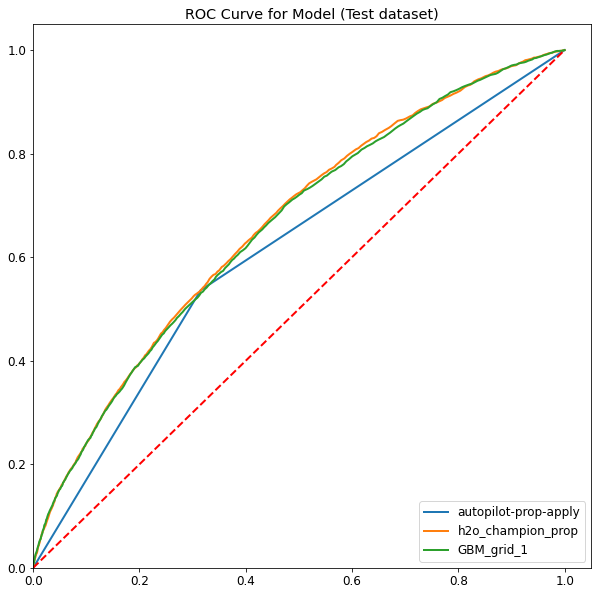

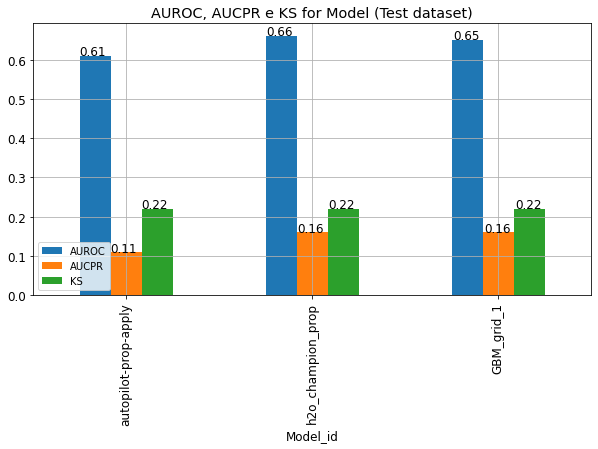

In [244]:
#Compare performance on the TEST dataset for all trained models
plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(10, 10))
for i in list_models:    
    if isinstance(i, h2o.estimators.gbm.H2OGradientBoostingEstimator):
        #Save all models in H20 format
        h2o.save_model(model=i, path='%s/models/candidates/' % OutputPath, force=True)
        #calculate o KS in test dataset
        h2o_predict = i.predict(test_hdf)
        data = h2o_predict.cbind(test_hdf[VarTarget]).as_data_frame()
        data['target0'] = 1 - data[VarTarget]
        data['bucket'] = pd.qcut(data['p1'], 10, duplicates='drop', labels=False)
        grouped = data.groupby('bucket', as_index=False)
        kstable = pd.DataFrame()
        kstable['min_prob'] = grouped.min()['p1']
        kstable['max_prob'] = grouped.max()['p1']
        kstable['events'] = grouped.sum()[VarTarget]
        kstable['nonevents'] = grouped.sum()['target0']    
        kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop=True)
        kstable['event_rate'] = (kstable.events / data[VarTarget].sum()).apply('{0:.2%}'.format)
        kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
        kstable['cum_eventrate'] = (kstable.events / data[VarTarget].sum()).cumsum()
        kstable['cum_noneventrate'] = (kstable.nonevents / data['target0'].sum()).cumsum()
        kstable['KS'] = np.round(kstable['cum_eventrate'] - kstable['cum_noneventrate'], 3)
        ks = kstable['KS'].max()

        #Ascertain the performance of all models on the test base
        performance = i.model_performance(test_hdf)

        #Salve metrics
        f=open("%s/models/candidates/performance_%s.csv" % (OutputPath, i.model_id), 'w')
        f.write(
            str(i.model_id) + ";"
            + str(performance.accuracy()[0][0]) + ";"
            + str(performance.auc()) + ';'
            + str(performance.aucpr()) + ';'
            + str(performance.logloss()) + ';'
            + str(ks) + ';'
            + str(performance.F1()[0][0]))
        f.write('\n')
        f.close()

        #graph with the ROC curve of all models
        fpr = performance.fprs
        tpr = performance.tprs
        plt.plot(fpr, tpr, lw=2, label=i.model_id.split("_")[0]+"_"+i.model_id.split("_")[1]+"_"+i.model_id.split("_")[2])
        plt.title("ROC Curve for Model (Test dataset)")    

        if i == list_models[0]:
            df_plot = pd.DataFrame({'Model_id': i.model_id.split("_")[0]+"_"+i.model_id.split("_")[1]+"_"+i.model_id.split("_")[2],
                                        'AUROC': int(performance.auc()*100)/100,
                                        'AUCPR': int(performance.aucpr()*100)/100,
                                        'KS': int(ks*100)/100
                                        }, index=[0])
        else:
            df_plot = df_plot.append(pd.DataFrame({'Model_id': i.model_id.split("_")[0]+"_"+i.model_id.split("_")[1]+"_"+i.model_id.split("_")[2],
                                        'AUROC': int(performance.auc()*100)/100,
                                        'AUCPR': int(performance.aucpr()*100)/100,
                                        'KS': int(ks*100)/100
                                        }, index=[0]))
            
    elif isinstance(i, sagemaker.predictor.Predictor):
        #Save model
        model_id = (sm.describe_endpoint_config(EndpointConfigName=sm.describe_endpoint(EndpointName=i.endpoint_name)['EndpointConfigName'])['ProductionVariants'][0]['ModelName'])
        text_file = open("%s/models/candidates/%s.py" % (OutputPath, model_id), "w")        
        text_file.write("""#recreate create_endpoint_config and create_endpoint for model %s
epc_name = "%s"
ep_config = sm.create_endpoint_config(
    EndpointConfigName=epc_name,
    ProductionVariants=[
        {
            "InstanceType": "ml.m5.2xlarge",
            "InitialInstanceCount": 1,
            "ModelName": "%s",
            "VariantName": "main",
        }
    ],
)

#Create end endpoint
ep_name = "%s"
create_endpoint_response = sm.create_endpoint(EndpointName=ep_name, EndpointConfigName=epc_name)
sm.get_waiter("endpoint_in_service").wait(EndpointName=ep_name)
print("ep_name: " + str(ep_name))

sm_predictor = Predictor(
    endpoint_name="%s",
    sagemaker_session=session,
    serializer=CSVSerializer(),
    deserializer=CSVDeserializer(),)""" % (model_id,
                                        model_id.replace('-model', '-epc'),
                                        model_id,
                                        model_id.replace('-model', '-ep'),
                                        model_id.replace('-model', '-ep')       
                                       )
                       )
        text_file.close()
        
        sm_predict = pd.DataFrame(i.predict(dataprep_df.query('partition_0 == "test_data"').loc[:, (selected_features)].to_csv(sep=",", header=False, index=False)))
        sm_predict.columns = ['predict', 'p1', 'probabilities']
        sm_predict['predict'] = sm_predict['predict'].astype(int)
        sm_predict['p1'] = sm_predict['p1'].astype(float)

        data = pd.concat([sm_predict.reset_index(drop=True), dataprep_df.query('partition_0 == "test_data"').reset_index(drop=True)[VarTarget]], axis=1)
        data['target0'] = 1 - data[VarTarget]
        data['bucket'] = pd.qcut(data['p1'], 10, duplicates='drop', labels=False)
        grouped = data.groupby('bucket', as_index=False)
        kstable = pd.DataFrame()
        kstable['min_prob'] = grouped.min()['p1']
        kstable['max_prob'] = grouped.max()['p1']
        kstable['events'] = grouped.sum()[VarTarget]
        kstable['nonevents'] = grouped.sum()['target0']
        kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop=True)
        kstable['event_rate'] = (kstable.events / data[VarTarget].sum()).apply('{0:.2%}'.format)
        kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
        kstable['cum_eventrate'] = (kstable.events / data[VarTarget].sum()).cumsum()
        kstable['cum_noneventrate'] = (kstable.nonevents / data['target0'].sum()).cumsum()
        kstable['cum_eventrate'] = kstable['cum_eventrate'].astype(float)
        kstable['cum_noneventrate'] = kstable['cum_noneventrate'].astype(float)
        kstable['KS'] = np.round(kstable['cum_eventrate'] - kstable['cum_noneventrate'], 3)
        ks = kstable['KS'].max()
        
        accuracy = metrics.accuracy_score(dataprep_df.query('partition_0 == "test_data"').reset_index(drop=True)[VarTarget].astype(str), sm_predict['predict'].astype(str))
        fpr, tpr, thresholds = metrics.roc_curve(dataprep_df.query('partition_0 == "test_data"').reset_index(drop=True)[VarTarget].astype(int), sm_predict['predict'].astype(int), pos_label=1)
        auc = metrics.auc(fpr, tpr)
        aucpr = metrics.average_precision_score(dataprep_df.query('partition_0 == "test_data"').reset_index(drop=True)[VarTarget].astype(int), sm_predict['predict'].astype(int), pos_label=1)
        f1 = metrics.f1_score(dataprep_df.query('partition_0 == "test_data"').reset_index(drop=True)[VarTarget].astype(str), sm_predict['predict'].astype(str), pos_label='1')
        log_loss = metrics.log_loss(dataprep_df.query('partition_0 == "test_data"').reset_index(drop=True)[VarTarget].astype(str), sm_predict['predict'].astype(str))
        
        #Salve metrics
        f=open("%s/models/candidates/performance_%s.csv" % (OutputPath, model_id), 'w')
        f.write(
            str(model_id) + ";"
            + str(accuracy) + ";"
            + str(auc) + ';'
            + str(aucpr) + ';'
            + str(log_loss) + ';'
            + str(ks) + ';'
            + str(f1))
        f.write('\n')
        f.close()
        
        plt.plot(fpr, tpr, lw=2, label=model_id.split("-")[0]+"-"+model_id.split("-")[1]+"-"+model_id.split("-")[2])
        plt.title("ROC Curve for Model (Test dataset)")
        
        if i == list_models[0]:
            df_plot = pd.DataFrame({'Model_id': model_id.split("-")[0]+"-"+model_id.split("-")[1]+"-"+model_id.split("-")[2],
                                        'AUROC': int(auc*100)/100,
                                        'AUCPR': int(aucpr*100)/100,
                                        'KS': int(ks*100)/100
                                        }, index=[0])
        else:
            df_plot = df_plot.append(pd.DataFrame({'Model_id': model_id.split("-")[0]+"-"+model_id.split("-")[1]+"-"+model_id.split("-")[2],
                                        'AUROC': int(auc*100)/100,
                                        'AUCPR': int(aucpr*100)/100,
                                        'KS': int(ks*100)/100
                                        }, index=[0]))
        
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right")
plt.show()
plt.close()
ax = df_plot.plot(kind='bar', x="Model_id", title="AUROC, AUCPR e KS for Model (Test dataset)", grid=True, figsize=(10,5), legend=1)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.legend(loc=3, prop={'size': 10})

In [ ]:
df_matrix = df_predict.reset_index().groupby([VarTarget, 'predict']).count()[['index']].reset_index().pivot(index=VarTarget, columns='predict', values='index').sort_values(by=[VarTarget], ascending=False).loc[:,(1,0)]

sns.heatmap(df_matrix, annot=True, center=True,cmap='Blues', fmt='g')
plt.show()
sns.heatmap(df_matrix/np.sum(df_matrix), annot=True,
            fmt='.2%', cmap='Blues')
plt.show()

## 4.4 Choose the best model among all tested

In [231]:
sort_metric_best_model='AUCPR'
#import all tested models and print the 10 bests sorted by AUC on the screen
modelos_testados = pd.concat(map(functools.partial(pd.read_csv, sep=';', header=None), glob.glob('%s/models/candidates/performance_*.csv' % OutputPath)))
modelos_testados.columns = ('model_id', 'accuracy', 'AUC', 'AUCPR', 'logloss', 'KS', 'F1')
modelos_testados = modelos_testados.sort_values(by=sort_metric_best_model, ascending=False)
modelos_testados = modelos_testados.drop_duplicates(subset=["model_id"])
print('MBest Models. Sorted by : ' + str(sort_metric_best_model))
modelos_testados.reset_index(0).head(30)

MBest Models. Sorted by : AUCPR


,index,model_id,accuracy,AUC,AUCPR,logloss,KS,F1
0,0,GBM_grid_1_AutoML_1_20220628_13109_model_7,0.492766,0.657022,0.169787,0.289870,0.225,0.127367
1,0,h2o_champion_prop_apply_prospects_v1220220628_171140,0.518036,0.660925,0.166613,0.289825,0.229,0.114218
2,0,autopilot-prop-apply-28-01-28-w1-015-63aeaca128-13-31-13-model,0.671351,0.610519,0.119256,11.351372,0.228,0.227481



BEST MODEL: GBM_grid_1_AutoML_1_20220628_13109_model_7



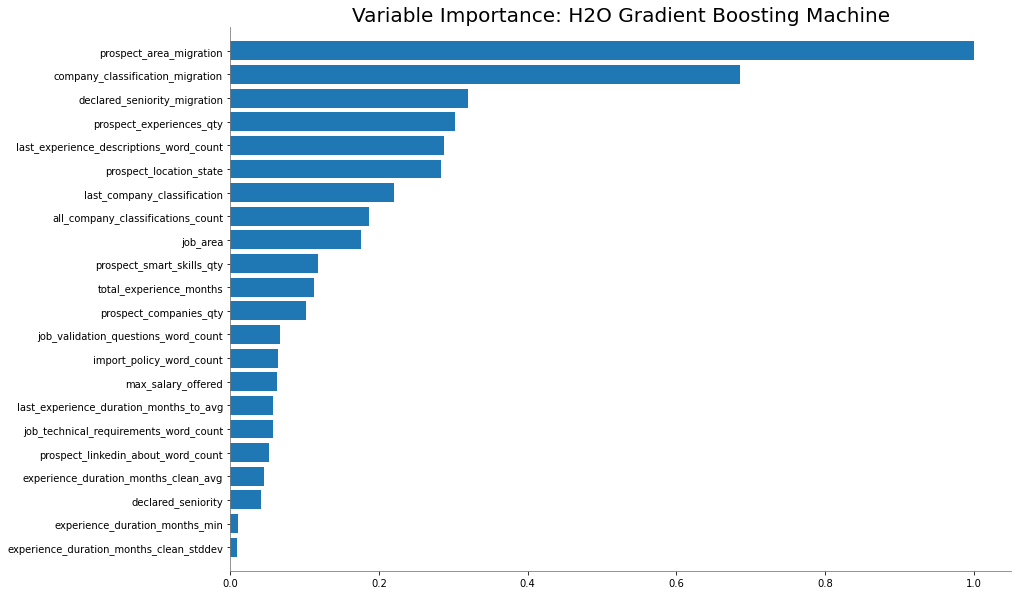

<Figure size 432x288 with 0 Axes>

In [239]:
#If you want to choose a model other than the first one on the list. Choose the position number:
posicao_melhor_modelo=0

plt.rcParams.update({'font.size': 10})
try:
    melhor_modelo = h2o.load_model('%s/models/candidates/%s' % (OutputPath, modelos_testados.iloc[posicao_melhor_modelo, 0]))
    (print("\n"+ "BEST MODEL: " + str(modelos_testados.iloc[posicao_melhor_modelo, 0]) + "\n"))
    
    melhor_modelo.varimp_plot(50)
except Exception as e:
    melhor_modelo = modelos_testados.iloc[posicao_melhor_modelo, 0]
    (print("\n"+ "BEST MODEL: " + str(melhor_modelo) + "\n"))
    print("Warning: This model doesn't have variable importances")

## 4.5 Stepwise for Analysis of the importance of variables and reduce the number of variables in the best model (Only for H2O)

In [35]:
#List all variables in the current model, ordered by variable importance
#For variables defined as a factor (which possibly are like dummys), remove the category from the name and leave only the orifinal name of the variable
try:
    df_features_sorted = melhor_modelo.varimp(True).variable.str.split('.', expand=True).drop_duplicates(subset = 0)[0].reset_index(drop=True)
except Exception as e:
    #As the model with ensemble in H20 does not show the importance of variables, we will include variables in selected_features
    df_features_sorted = selected_features

In [ ]:
#Define the number of variables to be increased with each new model. Try to put 10% or 20% of the total, as it can take a long time
qt_var=1
qt_total_var = len(df_features_sorted)

dict_model_tmp={}
dict_performance={}

for i in range(qt_var, qt_total_var+qt_var, qt_var):    
    df_features_sorted[0:i].values.tolist()    
    
    #If no model chosen is not an ensemble of models. Then use the same model for training with increment of variables
    melhor_modelo_tmp = melhor_modelo
    if melhor_modelo_tmp.model_id.lower().find("ensemble") == -1:
        dict_model_tmp[i] = melhor_modelo_tmp
        dict_model_tmp[i].train(x = df_features_sorted[0:i].values.tolist(),
                                y = var_target,
                                training_frame=train_hdf, 
                                validation_frame=valid_hdf)
    ##If it is not possible, for the home of an ensemble of models, use GradientBoostingEstimator to make the assessment
    else:
        dict_model_tmp[i] = H2OGradientBoostingEstimator(seed=1, model_id=str('model_tmp_%s' % i))
        dict_model_tmp[i].train(x = df_features_sorted[0:i].values.tolist(),
                                y = var_target,
                                training_frame=train_hdf, 
                                validation_frame=valid_hdf)       


    perform_oot = dict_model_tmp[i].model_performance(test_hdf)
    dict_performance_tmp = {}
    dict_performance_tmp['AUC'] = {'qt_var': i, 'medida': 'AUC', 'Validation_Dataset': dict_model_tmp[i].auc(valid=True), 'Test_Dataset': perform_oot.auc()}
    dict_performance_tmp['accuracy'] = {'qt_var': i, 'medida': 'accuracy', 'Validation_Dataset': dict_model_tmp[i].accuracy(valid=True)[0][0], 'Test_Dataset': perform_oot.accuracy()[0][0]}
    dict_performance_tmp['AUCPR'] = {'qt_var': i, 'medida': 'AUCPR', 'Validation_Dataset': dict_model_tmp[i].aucpr(valid=True), 'Test_Dataset': perform_oot.aucpr()}
    dict_performance_tmp['F1'] = {'qt_var': i, 'medida': 'F1', 'Validation_Dataset': dict_model_tmp[i].F1(valid=True)[0][0], 'Test_Dataset': perform_oot.F1()[0][0]}
    dict_performance_tmp['logloss'] = {'qt_var': i, 'medida': 'logloss', 'Validation_Dataset': dict_model_tmp[i].logloss(valid=True), 'Test_Dataset': perform_oot.logloss()}
    dict_performance[i] = pd.DataFrame(dict_performance_tmp).transpose()

In [ ]:
##Plot graph comparing the increase in performance with the increase in variables
for i in dict_performance.keys():
    if i == list(dict_performance.keys())[0]:
        df_performance = dict_performance[i]
    else:
        df_performance = df_performance.append(dict_performance[i], ignore_index=True)

lista_metricas_perf = df_performance['medida'].unique()

for i in range(len(lista_metricas_perf)):   
    #selects only the metric to be analyzed
    metrics_df_tmp = df_performance.query('medida == "%s"' % lista_metricas_perf[i])
    metrics_df_tmp = metrics_df_tmp.set_index('qt_var')
    del metrics_df_tmp['medida']
    if lista_metricas_perf[i] == 'logloss':
        max_oot = metrics_df_tmp[metrics_df_tmp['Test_Dataset'] == metrics_df_tmp.Test_Dataset.min()].index.values
    else:
        max_oot = metrics_df_tmp[metrics_df_tmp['Test_Dataset'] == metrics_df_tmp.Test_Dataset.max()].index.values
        
    if lista_metricas_perf[i] == sort_metric_best_model:
        max_oot_filtro = max_oot[0]        
    
    ax=metrics_df_tmp.plot(figsize=(15,5), linewidth=2, fontsize=10, marker='D', ms=5,\
                            title='Best %s with %s Variables' % (lista_metricas_perf[i].upper(), str(max_oot[0])))
    plt.xlabel('Variables Number')
    plt.ylabel('%s' % lista_metricas_perf[i].upper())
    plt.grid(axis='y')
    plt.legend(loc=0, prop={'size': 12})
    #display(ax)

In [ ]:
print('Consider removing the following variables: '+ str(df_features_sorted[df_features_sorted.index > int(max_oot_filtro)].values.tolist()))

# 5. Exporting the best model to Deploy

In [240]:
try:
    #Save the H2O model in MOJO format and all the variables of the best model
    melhor_modelo = h2o.load_model('%s/models/candidates/%s' % (OutputPath, modelos_testados.iloc[posicao_melhor_modelo, 0]))
    path_model_mojo = melhor_modelo.download_mojo('%s/models/best/' % OutputPath, get_genmodel_jar=True)
    print('path_model_mojo: ' + str(path_model_mojo))
    caminho_modelo_h2o = h2o.save_model(model=melhor_modelo, path='%s/models/best/' % OutputPath, force=True)
except Exception as e:
    src_path = "%s/models/candidates/%s.py" % (OutputPath, model_id)
    dst_path = "%s/models/best/%s.py" % (OutputPath, model_id)
    shutil.copy(src_path, dst_path)
    print('path_sagemaker_model: ' + str(dst_path))

path_model_mojo: /home/sagemaker-user/data-science-lab/tamplates/output_model/models/best/GBM_grid_1_AutoML_1_20220628_13109_model_7.zip


Detected 1 unused columns in the input data set: {}


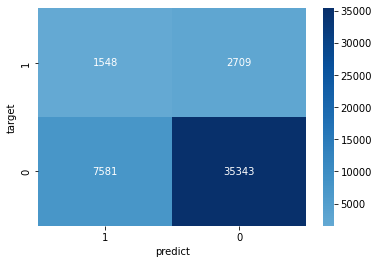

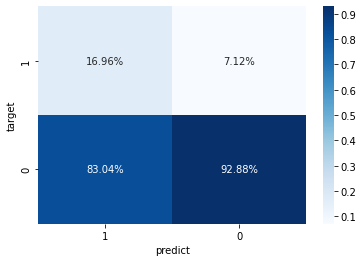

In [17]:
#Confusion Matrix for the Champion
df_predict_tmp = h2o.mojo_predict_pandas(dataprep_df.query('partition_0 == "test_data"').loc[:, (selected_features+[VarTarget])], mojo_zip_path=path_model_mojo, verbose=False)

df_predict = pd.concat([df_predict_tmp.reset_index(drop=True), dataprep_df.query('partition_0 == "test_data"').loc[:, (selected_features+[VarTarget])].reset_index(drop=True)], axis=1)

df_matrix = df_predict.reset_index().groupby([VarTarget, 'predict']).count()[['index']].reset_index().pivot(index=VarTarget, columns='predict', values='index').sort_values(by=[VarTarget], ascending=False).loc[:,(1,0)]

sns.heatmap(df_matrix, annot=True, center=True,cmap='Blues', fmt='g')
plt.show()
sns.heatmap(df_matrix/np.sum(df_matrix), annot=True,
            fmt='.2%', cmap='Blues')
plt.show()

## 5.1 Cleaning Resources

In [249]:
sm.delete_endpoint(EndpointName=ep_name)
sm.delete_endpoint_config(EndpointConfigName=epc_name)

# 6. Save final dataset with predictions into S3 to explain the model

In [31]:
csv_buffer = StringIO()
df_predict.to_csv(csv_buffer, index=False, header=True)
s3_resource = my_boto3_session.resource('s3')
s3_resource.Object(bucket, 'databases/%s/%s.csv' % (ModelName+'_scored', ModelName+'_scored')).put(Body=csv_buffer.getvalue())
del csv_buffer

In [32]:
glue = my_boto3_session.client('glue', region_name="us-east-1")

glue.update_crawler(Name='data-science-lab',
                    Targets={'S3Targets': [{'Path': 's3://%s/databases/%s' % (bucket, ModelName+'_scored'),
                               'Exclusions': []}]})

glue.start_crawler(Name='data-science-lab')

{'ResponseMetadata': {'RequestId': 'fbb2996c-95cb-4853-940d-b63456615a49',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Sat, 02 Jul 2022 19:18:46 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '2',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'fbb2996c-95cb-4853-940d-b63456615a49'},
  'RetryAttempts': 0}}